In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load dataset
data = pd.read_csv('dataset/tmdb_5000_movies.csv')
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [ ]:
# Convert 'release_date' to datetime
data['release_date'] = pd.to_datetime(data['release_date'], errors='coerce')

# Extract year and convert to float
data['release_year'] = data['release_date'].dt.year.astype(float)

# Drop rows with missing 'release_year'
data = data.dropna(subset=['release_year'])

print(data['release_year'])

0       2009.0
1       2007.0
2       2015.0
3       2012.0
4       2012.0
         ...  
4798    1992.0
4799    2011.0
4800    2013.0
4801    2012.0
4802    2005.0
Name: release_year, Length: 4802, dtype: float64


In [ ]:
# Preprocess the data
# Selecting relevant columns
features = data[['genres', 'vote_average', 'release_year']]

In [29]:
# Encode 'Genre' using One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore')
genre_encoded = encoder.fit_transform(features[['genres']]).toarray()
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(['genres']))

In [30]:
# Combine encoded genres with other features
features = pd.concat([genre_encoded_df, features[['vote_average', 'release_year']]], axis=1)
print(features.head)

<bound method NDFrame.head of       genres_[]  \
0           0.0   
1           0.0   
2           0.0   
3           0.0   
4           0.0   
...         ...   
4798        0.0   
4799        0.0   
4800        1.0   
4801        0.0   
4802        NaN   

      genres_[{"id": 10402, "name": "Music"}, {"id": 10749, "name": "Romance"}]  \
0                                                   0.0                           
1                                                   0.0                           
2                                                   0.0                           
3                                                   0.0                           
4                                                   0.0                           
...                                                 ...                           
4798                                                0.0                           
4799                                                0.0                      

In [31]:
# Normalize numerical features
scaler = StandardScaler()
features[['vote_average', 'release_year']] = scaler.fit_transform(features[['vote_average', 'release_year']])

In [ ]:
features = features.dropna()
#Apply K-Means clustering
k = 5  # Number of clusters (adjust based on elbow method)
# Train the model
kmeans = KMeans(n_clusters=k, random_state=42)
features['Cluster'] = kmeans.fit_predict(features.drop(columns='Cluster', errors='ignore'))


In [ ]:
# Evaluate clustering using silhouette score
score = silhouette_score(features.drop(columns='Cluster'), features['Cluster'])
print(f'Silhouette Score: {score}')

Silhouette Score: 0.15706171848838957


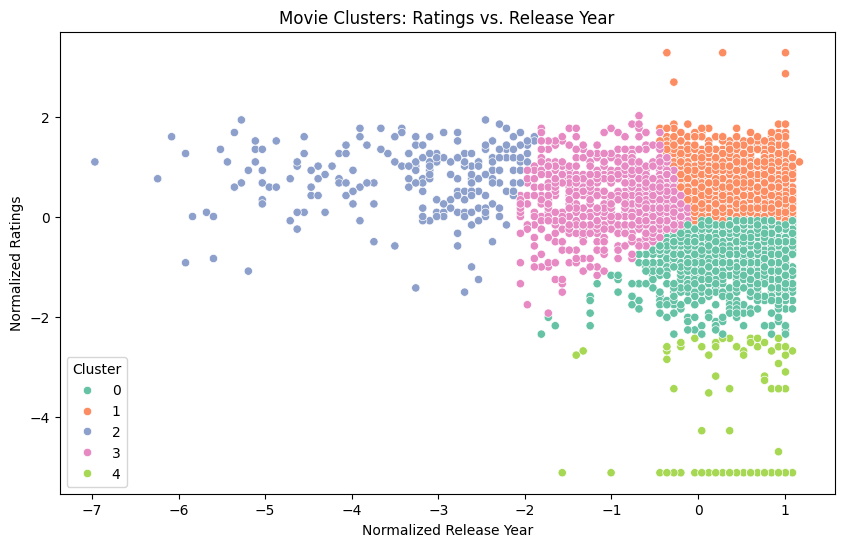

In [ ]:
# Visualize clusters (e.g., Ratings vs. ReleaseYear)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=features, x='release_year', y='vote_average', hue='Cluster', palette='Set2')
plt.title('Movie Clusters: Ratings vs. Release Year')
plt.xlabel('Normalized Release Year')
plt.ylabel('Normalized Ratings')
plt.legend(title='Cluster')
plt.show()


In [35]:
import pickle
# Save the trained model
with open('kmeans_model.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

# Save the encoder and scaler
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

with open('encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)


In [38]:
# Load the saved models
with open('kmeans_model.pkl', 'rb') as file:
    kmeans = pickle.load(file)

with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)

with open('encoder.pkl', 'rb') as file:
    encoder = pickle.load(file)

# Preprocess new data
new_data = pd.DataFrame({
    'genres': ['Action', 'Drama', 'Action'],
    'vote_average': [8.5, 7.3, 3.0],
    'release_year': [2022, 2019, 2023]
})

genre_encoded = encoder.transform(new_data[['genres']]).toarray()
genre_encoded_df = pd.DataFrame(genre_encoded, columns=encoder.get_feature_names_out(['genres']))
new_features = pd.concat([genre_encoded_df, new_data[['vote_average', 'release_year']]], axis=1)

new_features[['vote_average', 'release_year']] = scaler.transform(new_features[['vote_average', 'release_year']])
new_clusters = kmeans.predict(new_features)

print(f'Predicted Clusters: {new_clusters}')


Predicted Clusters: [1 1 4]
